In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [3]:
sns.set(rc={'figure.figsize': (16, 8)})
sns.set_style('whitegrid')

In [4]:
import covid_pso
import pso

# South-Korea Simulation

In [5]:
KOREA_SPECIFIC_PARAMETERS = {
    # Population
    "population_size": 51.25,
    "initial_cases": 1.0,
    "external_force_of_infection": 1.0,
    "simulation_days": 365.0,
    # Case Isolation
    "case_isolation_begin": 0.0,
    "case_isolation_range": 365.0,
    # General Contact Reduction
    "contact_reduction_begin": 95.0,
    "contact_reduction_range": 365.0,
}

KOREA_PARAMETERS = {
    **covid_pso.DEFAULT_PARAMETERS,
    **KOREA_SPECIFIC_PARAMETERS,
}

In [6]:
reference_df = pd.read_csv("SouthKorea.csv")
reference_df.index = reference_df.index.rename("days")

reference_df = reference_df.iloc[80:] # Throw away early lines
reference_df['infected'] = reference_df['totalCases'] - reference_df['dead'] - reference_df['recoveredCases']

In [7]:
free_parameters_with_bounds = {
#     "symptomatic_course_of_disease": (0, 100),
#     "medical_consultations_by_symptomatic_cases": (0, 100),
#     "hospitalisation_of_symptomatic_cases": (1, 50),
    "basic_reproduction_number": (2.0, 4.4),
    "symptomatic_cases_to_be_isolated": (70, 100),
    "contact_reduction_home_isolation": (70, 100),
    "contact_reduction_factor": (40, 98),
}

free_parameters_scales = {
    "basic_reproduction_number": 0.1,
    "symptomatic_cases_to_be_isolated": 5.,
    "contact_reduction_home_isolation": 5.,
    "contact_reduction_factor": 5.,
}


def embed_free_parameters(free_parameters, extra_parameters={}):
    return {
        **KOREA_PARAMETERS,
        **{
            name: free_parameters[ix]
            for ix, name in enumerate(free_parameters_with_bounds)
        },
        **extra_parameters,
    }

In [8]:
# good_free_parameters = [ 3.72534489, 87.41577661, 83.78593428, 53.43468564] # mae, distancing >= 40
# good_free_parameters = [ 3.72944433, 83.55811024, 87.29068416, 66.34712788] # mae, distancing >= 60

# good_free_parameters = [3.44368039, 75.9971663,  84.11184834, 53.46808436] # rmse, distancing >= 20
good_free_parameters = [3.34287844, 77.12386301, 77.85641205, 60.] # rmse, distancing >= 60

simulation_result = covid_pso.simulate(embed_free_parameters(good_free_parameters))
simulation_df = covid_pso.parse_result(simulation_result)
simulation_df.to_csv('south_korea_sim.csv')

In [9]:
def mcmc_simulations(loc, scale, num_samples=250, extra_parameters={}):
    free_parameterss = np.random.normal(loc=loc, scale=scale, size=[num_samples, len(loc)])
    responses = [
        covid_pso.simulate_async(
            embed_free_parameters(free_parameters, extra_parameters=extra_parameters),
            url=f'http://localhost:{np.random.choice(3000 + np.arange(32))}',
        )
        for free_parameters in free_parameterss
    ]
    
    async def parse_result(response):
        return covid_pso.parse_result(await response)
    
    dfs = [
        parse_result(response)
        for response in responses
    ]
    return asyncio.run(asyncio.gather(*dfs))

In [10]:
sample_dfs = mcmc_simulations(good_free_parameters, list(free_parameters_scales.values()))

In [19]:
def quantile_plot(sample_dfs, column, color):
    quantile_df = pd.concat([sample_df[column] for sample_df in sample_dfs], axis=1)
    plt.fill_between(
        quantile_df.index,
        quantile_df.quantile(0.2, axis=1),
        quantile_df.quantile(0.8, axis=1),
        color=color,
        alpha=0.25,
    )
    plt.fill_between(
        quantile_df.index,
        quantile_df.quantile(0.35, axis=1),
        quantile_df.quantile(0.65, axis=1),
        color=color,
        alpha=0.4,
    )
    plt.fill_between(
        quantile_df.index,
        quantile_df.quantile(0.45, axis=1),
        quantile_df.quantile(0.55, axis=1),
        color=color,
        alpha=0.4,
    )    

(0.0, 1000.0)

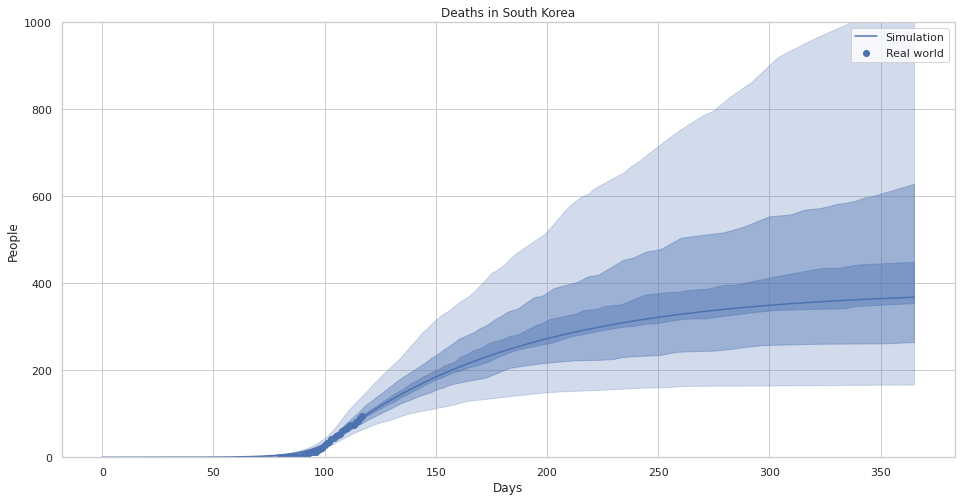

In [20]:
quantile_plot(sample_dfs, 'dead', 'C0')

plt.plot(
    simulation_df['dead'],
    label='Simulation',
)
plt.scatter(reference_df.index, reference_df['dead'], label='Real world')

plt.legend()
plt.title('Deaths in South Korea')
plt.xlabel('Days')
plt.ylabel('People')

plt.ylim([0, 1000])
# plt.yscale('log')

# True infection estimation

Text(0, 0.5, 'People')

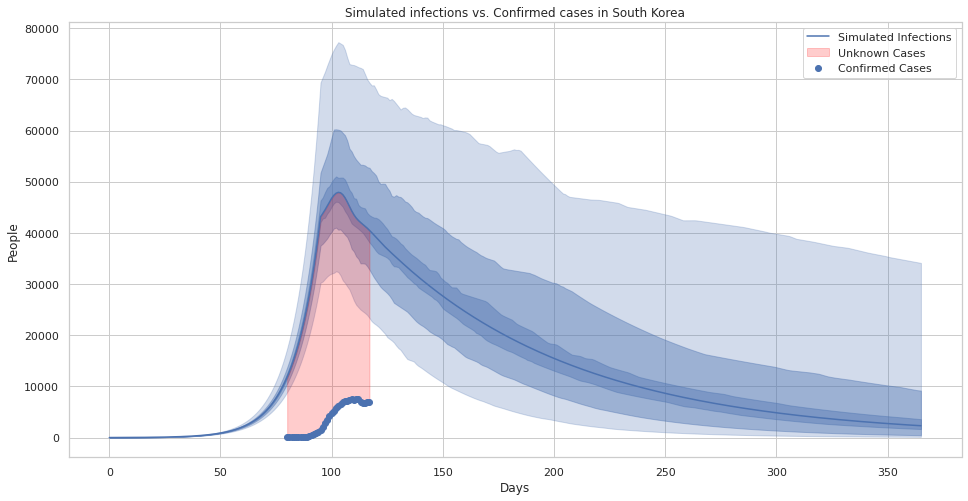

In [21]:
quantile_plot(sample_dfs, 'infected', 'C0')

plt.fill_between(
    reference_df.index,
    reference_df['infected'],
    simulation_df.loc[reference_df.index]['infected'],
    color='red',
    alpha=0.2,
    label='Unknown Cases',
)

plt.plot(
    simulation_df['infected'],
    label='Simulated Infections',
)
plt.scatter(reference_df.index, reference_df['infected'], label='Confirmed Cases')

plt.legend()
plt.title('Simulated infections vs. Confirmed cases in South Korea')
plt.xlabel('Days')
plt.ylabel('People')

# Effects of Social Distancing

In [14]:
no_dist_parameters = {
    'contact_reduction_factor': 0.0,
    'case_isolation_range': 105.,
}

no_dist_simulation_result = covid_pso.simulate(
    embed_free_parameters(
        good_free_parameters,
        extra_parameters=no_dist_parameters,
    )
)

no_dist_simulation_df = covid_pso.parse_result(no_dist_simulation_result)
no_dist_simulation_df.to_csv('south_korea_sim_no_distancing.csv')

In [15]:
no_dist_sample_dfs = mcmc_simulations(
    good_free_parameters, list(free_parameters_scales.values()),
    extra_parameters=no_dist_parameters,
)

Text(0, 0.5, 'People')

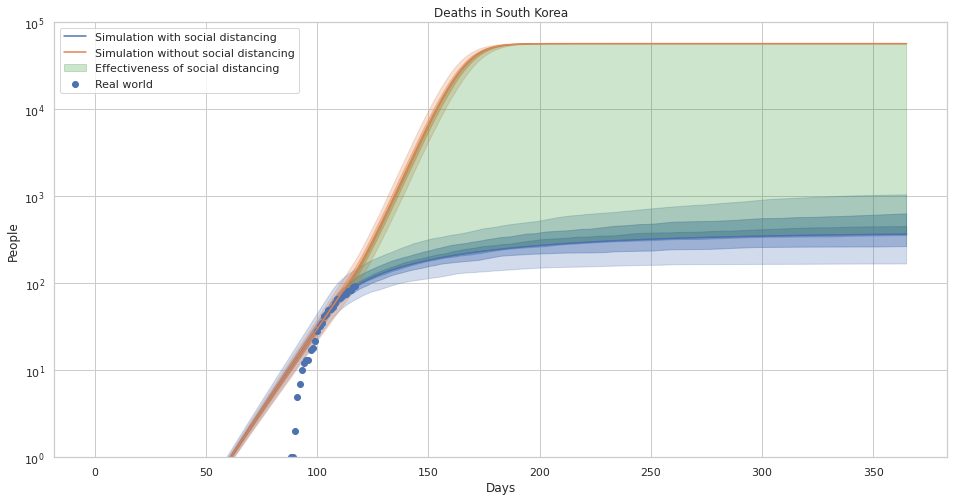

In [22]:
quantile_plot(sample_dfs, 'dead', 'C0')
quantile_plot(no_dist_sample_dfs, 'dead', 'C1')

plt.fill_between(
    simulation_df.index,
    simulation_df['dead'],
    no_dist_simulation_df['dead'],
    color='green',
    alpha=0.2,
    label='Effectiveness of social distancing',
)

plt.plot(
    simulation_df['dead'],
    label='Simulation with social distancing',
)
plt.plot(
    no_dist_simulation_df['dead'],
    label='Simulation without social distancing',
)
plt.scatter(reference_df.index, reference_df['dead'], label='Real world')

plt.ylim([1, 10 ** 5])
plt.yscale('log')

plt.legend()
plt.title('Deaths in South Korea')
plt.xlabel('Days')
plt.ylabel('People')

Text(0, 0.5, 'People')

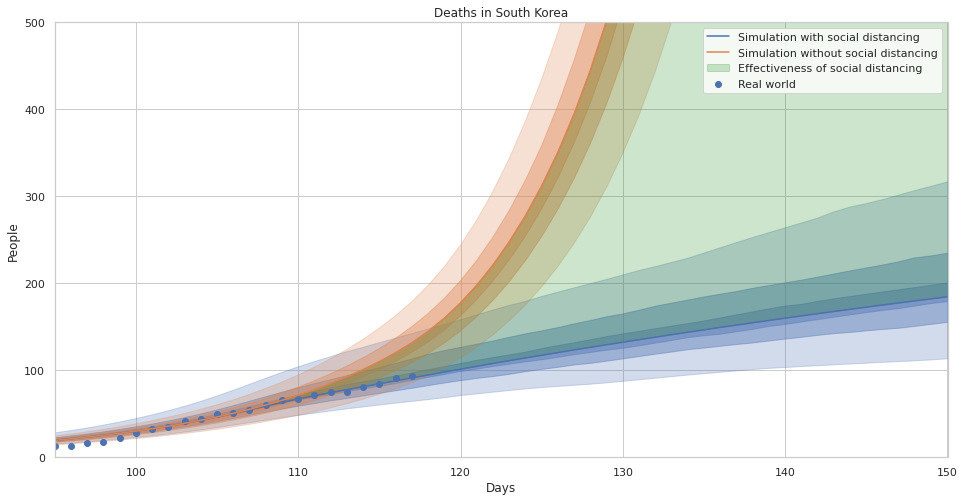

In [23]:
quantile_plot(sample_dfs, 'dead', 'C0')
quantile_plot(no_dist_sample_dfs, 'dead', 'C1')

plt.fill_between(
    simulation_df.index,
    simulation_df['dead'],
    no_dist_simulation_df['dead'],
    color='green',
    alpha=0.2,
    label='Effectiveness of social distancing',
)

plt.plot(
    simulation_df['dead'],
    label='Simulation with social distancing',
)
plt.plot(
    no_dist_simulation_df['dead'],
    label='Simulation without social distancing',
)
plt.scatter(reference_df.index, reference_df['dead'], label='Real world')

plt.legend()
plt.title('Deaths in South Korea')

plt.xlim([95, 150])
plt.ylim([0, 500])
plt.xlabel('Days')
plt.ylabel('People')

Text(0, 0.5, 'People')

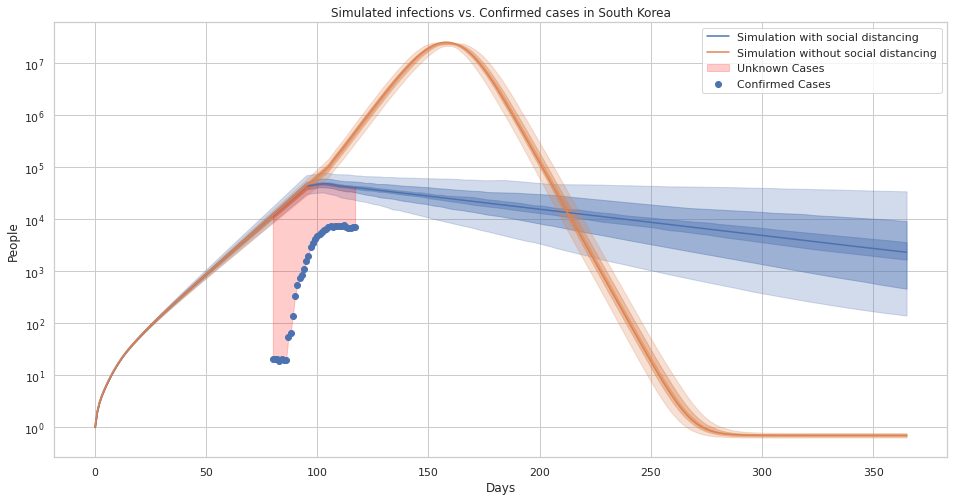

In [24]:
quantile_plot(sample_dfs, 'infected', 'C0')
quantile_plot(no_dist_sample_dfs, 'infected', 'C1')

plt.fill_between(
    reference_df.index,
    reference_df['infected'],
    simulation_df.loc[reference_df.index]['infected'],
    color='red',
    alpha=0.2,
    label='Unknown Cases',
)

plt.plot(
    simulation_df['infected'],
    label='Simulation with social distancing',
)
plt.plot(
    no_dist_simulation_df['infected'],
    label='Simulation without social distancing',
)
plt.scatter(reference_df.index, reference_df['infected'], label='Confirmed Cases')

plt.legend()
plt.title('Simulated infections vs. Confirmed cases in South Korea')

plt.yscale('log')
plt.xlabel('Days')
plt.ylabel('People')